# Classify snow-covered area (SCA) in Sentinel-2, Landsat 8/9, and PlanetScope imagery: full pipelines

Rainey Aberle

Department of Geosciences, Boise State University

2022

### Requirements:
- Area of Interest (AOI) shapefile: used to query and crop imagery 
- Google Earth Engine (GEE) account: used to query imagery and the DEM (if no DEM is provided). Sign up for a free account [here](https://earthengine.google.com/new_signup/). 
- Digital elevation model (DEM; _optional_): used to extract elevations over the AOI and for each snowline. If no DEM is provided, the ArcticDEM Mosaic will be used where there is coverage; otherwise, the NASADEM will be used.
- PlanetScope 4-band Surface Reflectance images (_optional_): download using the `Planet_images_order_download.ipynb` or through Planet Explorer. 

### Outline:
__0. Setup__ paths in directory, file locations, authenticate GEE - _modify this section!_

__1. Sentinel-2 Top of Atmosphere (TOA) imagery:__ full pipeline

__2. Sentinel-2 Surface Reflectance (SR) imagery:__ full pipeline

__3. Landsat 8/9 Surface Reflectance (SR) imagery:__ full pipeline

__4. PlanetScope Surface Reflectance (SR) imagery:__ full pipeline

-------


### 0. Setup

#### Define paths in directory and desired settings. 
Modify lines located within the following:

`#### MODIFY HERE ####`  

`#####################`

In [3]:
# -----Import packages
import xarray as xr
import os
import numpy as np
import glob
from matplotlib import pyplot as plt
import geopandas as gpd
import sys
import ee
import json
from tqdm.auto import tqdm
from joblib import load
from shapely.geometry import MultiPolygon, Polygon
import warnings
warnings.filterwarnings('ignore')

##### MODIFY HERE #####

# -----Paths in directory
site_name = 'White' # used for output file names
# path to glacier-snow-cover-mapping code
base_path = r'C:\Users\WilsonSIRL5-MCY-E113\Documents\Backup\glacier-snow-cover-mapping-for-ANP-and-SNP'
# path to AOI file
aoi_fn = os.path.join(base_path, 'outline', site_name, 'glims_polygons.shp')
# path to folder containing DEM raster file
dem_path = os.path.join(base_path, 'DEMs')
# DEM file name
# Note: set dem_fn=None if you want to use the ArcticDEM or NASADEM via Google Earth Engine
dem_fn = None
# path for output images
out_path = os.path.join(base_path,'study-sites', site_name)
# path to PlanetScope images
# Note: set ps_im_path=None if not using PlanetScope
ps_im_path = None
# path for output figures
figures_out_path = os.path.join(out_path, 'figures')

# -----Determine whether to mask clouds using the respective cloud masking data products
# NOTE: Cloud mask products anecdotally are less accurate over glacierized/snow-covered surfaces. 
# If the cloud masks are consistently masking large regions or your study site, I suggest testing with mask_clouds = False
mask_clouds = True

# -----Define image search filters
year_start = 2023
year_end = 2024
# Define the fixed MM-DD range within each year
date_start_mmdd = "06-01"
date_end_mmdd = "09-30"
cloud_cover_max = 20 # maximum cloud cover percentage according to the image metadata
aoi_coverage = 50 # total portion of AOI covered after filtering clouds

# -----Determine image download, clipping & plotting settings
# Note: if im_download = False, but images over the aoi exceed GEE limit, images must be downloaded regardless.
im_download = True  # = True to download all satellite images by default
plot_results = True # = True to plot figures of results for each image where applicable
verbose = True # = True to print details for each image during each step
skip_clipped = False # = True to skip PlanetScope images where bands appear "clipped", i.e. max(blue) < 0.8

#######################

# -----Make output directory if it doesn't exist
if not os.path.exists(out_path):
    os.mkdir(out_path)
    print('Made directory for outputs: ', out_path)

# -----Set paths for output files
s2_toa_im_path = os.path.join(out_path, 'Sentinel-2_TOA')
s2_sr_im_path = os.path.join(out_path, 'Sentinel-2_SR')
l_im_path = os.path.join(out_path, 'Landsat')
im_classified_path = os.path.join(out_path, 'classified')
stats_path = os.path.join(out_path, 'snow_cover_stats')

# -----Add path to functions
sys.path.insert(1, os.path.join(base_path, 'notebooks', 'functions'))
import pipeline_utils_updated as f
import importlib
importlib.reload(f)  # Reload to apply recent changes

# -----Load dataset dictionary
dataset_dict_fn = os.path.join(base_path, 'inputs-outputs', 'datasets_characteristics.json')
dataset_dict = json.load(open(dataset_dict_fn))

#### Authenticate and initialize Google Earth Engine (GEE). 

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back into the space below this cell when prompted. 

In [4]:
try:
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except: 
    ee.Authenticate()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')


Successfully saved authorization token.


#### Load AOI and DEM

Optimal UTM CRS = EPSG:32615
Clipped ArcticDEM referenced to the geoid already exists in directory, loading...


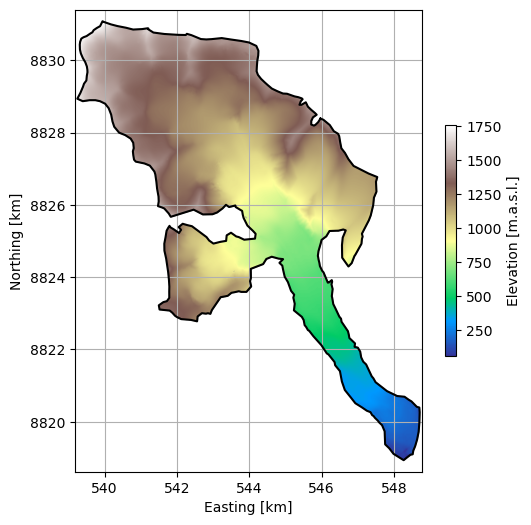

In [5]:
# -----Load AOI as gpd.GeoDataFrame
aoi = gpd.read_file(aoi_fn)
# reproject the AOI to WGS84 to solve for the optimal utm zone
aoi_wgs = aoi.to_crs('EPSG:4326')
aoi_wgs_centroid = [aoi_wgs.geometry[0].centroid.xy[0][0],
                    aoi_wgs.geometry[0].centroid.xy[1][0]]
# grab the optimal UTM zone EPSG code
epsg_utm = f.convert_wgs_to_utm(aoi_wgs_centroid[0], aoi_wgs_centroid[1])
print('Optimal UTM CRS = EPSG:' + str(epsg_utm))
# reproject AOI to the optimal UTM zone
aoi_utm = aoi.to_crs('EPSG:'+epsg_utm)

# -----Load DEM as Xarray DataSet
if dem_fn is None:
    # query GEE for DEM
    dem = f.query_gee_for_dem(aoi_utm, base_path, site_name, dem_path)
else:
    # load DEM as xarray DataSet
    dem = xr.open_dataset(os.path.join(dem_path, dem_fn))
    dem_crs = str(dem.rio.crs.to_epsg())
    dem = f.adjust_dem_data_vars(dem)
    # set no data values to NaN
    dem = xr.where((dem > 1e38) | (dem <= -9999), np.nan, dem)
    # reproject the DEM to the optimal utm zone
    dem = dem.rio.write_crs('EPSG:' + dem_crs)
    if dem_crs is not epsg_utm:
        dem = dem.rio.reproject('EPSG:' + epsg_utm).rio.write_crs('EPSG:'+str(epsg_utm))

# -----Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dem_im = ax.imshow(dem.elevation.data, cmap='terrain', 
          extent=(np.min(dem.x.data)/1e3, np.max(dem.x.data)/1e3, np.min(dem.y.data)/1e3, np.max(dem.y.data)/1e3))
if type(aoi_utm.geometry[0])==Polygon:
    ax.plot([x/1e3 for x in aoi_utm.geometry[0].exterior.coords.xy[0]],
            [y/1e3 for y in aoi_utm.geometry[0].exterior.coords.xy[1]], '-k')
elif type(aoi_utm.geometry[0])==MultiPolygon:
    [ax.plot([x/1e3 for x in geom.exterior.coords.xy[0]],
            [y/1e3 for y in geom.exterior.coords.xy[1]], '-k') for geom in aoi_utm.geometry[0].geoms]
ax.grid()
ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')
fig.colorbar(dem_im, ax=ax, shrink=0.5, label='Elevation [m.a.s.l.]')
plt.show()

## 1. Landsat 8/9 SR imagery

In [5]:
# -----Query GEE for imagery (and download to l_im_path if necessary)
# Define dataset
dataset = 'Landsat'
# Load trained image classifier
clf_fn = os.path.join(base_path, 'inputs-outputs', 'Landsat_classifier_all_sites.joblib')
clf = load(clf_fn)
# Load feature columns (bands to use in classification)
feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'Landsat_feature_columns.json')
feature_cols = json.load(open(feature_cols_fn))
# Run the classification pipeline
run_pipeline=True
f.query_gee_for_imagery(dataset_dict, dataset, aoi_utm, dem, year_start, year_end, date_start_mmdd, date_end_mmdd,
                        mask_clouds, cloud_cover_max, aoi_coverage, run_pipeline, site_name, 
                        clf, feature_cols, im_download, l_im_path, im_classified_path, 
                        stats_path, figures_out_path, plot_results, verbose)
         

Landsat images must be downloaded for full spatial resolution
Splitting full date range into annual date ranges
Iterating over date ranges
Processing date range: 2013-06-15 to 2013-09-15
Querying GEE for all images meeting search criteria...
8 total images found
4 total images will remain after mosaicking


  0%|          | 0/4 [00:00<?, ?it/s]

Processing date range: 2014-06-15 to 2014-09-15
Querying GEE for all images meeting search criteria...
4 total images found
2 total images will remain after mosaicking


  0%|          | 0/2 [00:00<?, ?it/s]

Processing date range: 2015-06-15 to 2015-09-15
Querying GEE for all images meeting search criteria...
8 total images found
4 total images will remain after mosaicking


  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 2. Sentinel-2 TOA imagery

Sentinel-2 SR imagery is only available starting ~2019, so run Sentinel-2 TOA pipeline if needing observations before 2019.

In [6]:
# -----Query GEE for imagery and run classification pipeline
# Define dataset
dataset = 'Sentinel-2_TOA'
# Load trained image classifier
clf_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_TOA_classifier_all_sites.joblib')
clf = load(clf_fn)
# Load feature columns (bands to use in classification)
feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_TOA_feature_columns.json')
feature_cols = json.load(open(feature_cols_fn))
# Run the classification pipeline
run_pipeline=True
f.query_gee_for_imagery(dataset_dict, dataset, aoi_utm, dem, year_start, year_end, date_start_mmdd, date_end_mmdd,
                        mask_clouds, cloud_cover_max, aoi_coverage, run_pipeline, site_name, 
                        clf, feature_cols, im_download, s2_toa_im_path, im_classified_path, 
                        stats_path, figures_out_path, plot_results, verbose)                               

Sentinel-2_TOA images must be downloaded for full spatial resolution
Splitting full date range into annual date ranges
Iterating over date ranges
Processing date range: 2023-06-01 to 2023-09-30
Querying GEE for all images meeting search criteria...
111 total images found
31 total images will remain after mosaicking


  0%|          | 0/31 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 3. Sentinel-2 SR imagery

In [4]:
# -----Query GEE for imagery and run classification pipeline
# Define dataset
dataset = 'Sentinel-2_SR'
# Load trained image classifier
clf_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_SR_classifier_all_sites.joblib')
clf = load(clf_fn)
# Load feature columns (bands to use in classification)
feature_cols_fn = os.path.join(base_path, 'inputs-outputs', 'Sentinel-2_SR_feature_columns.json')
feature_cols = json.load(open(feature_cols_fn))
# Run the classification pipeline
run_pipeline=True
f.query_gee_for_imagery(dataset_dict, dataset, aoi_utm, dem, year_start, year_end, date_start_mmdd, date_end_mmdd,
                        mask_clouds, cloud_cover_max, aoi_coverage, run_pipeline, site_name, 
                        clf, feature_cols, im_download, s2_sr_im_path, im_classified_path, 
                        stats_path, figures_out_path, plot_results, verbose)

Sentinel-2_SR images must be downloaded for full spatial resolution
Splitting full date range into annual date ranges
Iterating over date ranges
Processing date range: 2023-06-15 to 2023-09-15
Querying GEE for all images meeting search criteria...
12 total images found
7 total images will remain after mosaicking


  0%|          | 0/7 [00:00<?, ?it/s]

Snowline saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\Coronation\snow_cover_stats\20230728T122424_Coronation_Sentinel-2_SR_snow_cover_stats.csv
Figure saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\Coronation\figures\20230728T122424_Coronation_Sentinel-2_SR_snow_cover.png
Snowline saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\Coronation\snow_cover_stats\20230725T121427_Coronation_Sentinel-2_SR_snow_cover_stats.csv
Figure saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\Coronation\figures\20230725T121427_Coronation_Sentinel-2_SR_snow_cover.png
Snowline saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\Coronation\snow_cover_stats\20230806T120428_Coronation_Sentinel-2_SR_snow_cover

EEException: Image.rename: Parameter 'input' is required and may not be null.